In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter

In [83]:
df = pd.read_csv("../data/survey_results.csv")
zero_shot = df[df["context"]==0].copy()
zero_shot = zero_shot.rename(columns={"mimesis": "mimesis_zero_shot"})
with_context = df[df["context"]==1].copy()
with_context = with_context.rename(columns={"mimesis": "mimesis_with_context"})
zero_shot = zero_shot.drop(columns=["context"])
with_context = with_context.drop(columns=["context"])
df = zero_shot.merge(with_context, on=["model", "task", "participant", "prompt_id", "gender", "political_lean", "understanding"], how="outer")
df["mimesis_change"] = df["mimesis_with_context"] - df["mimesis_zero_shot"]

df["user_id"] = df["participant"]
df["is_man"] = (df["gender"]=="man").astype(int)
df["is_liberal"] = (df["political_lean"].isin(["Liberal", "Very Liberal"])).astype(int)
df = df[["mimesis_change", "understanding", "user_id", "model", "task", "prompt_id", "is_man", "is_liberal"]]
df["prompt_id"] = df["prompt_id"].str.replace("-", "_")
df.to_csv("../data/regression/mimesis_change.csv", index=False)

In [4]:
df = pd.read_csv("../data/survey_results.csv")
df["user_id"] = df["participant"]

df["understanding"] = df["understanding"] - 3

df["is_man"] = (df["gender"]=="man").astype(int)
df["has_left_politics"] = (df["political_lean"].isin(["Liberal", "Very Liberal"])).astype(int)

df = df[["mimesis", "context", "understanding", "user_id", "model", "task", "prompt_id", "is_man", "has_left_politics"]]

df["prompt_id"] = df["prompt_id"].str.replace("aita-", "Scenario: ")
df["prompt_id"] = df["prompt_id"].str.replace("politics-", "Topic: ")
df["prompt_id"] = df["prompt_id"].str.replace("-", " ")

df.to_csv("../data/regression/mimesis.csv", index=False)
len(df)/4

380.0

In [28]:
topics = pd.read_csv("../data/topics_labeled.csv")
topics["topic_num"] = topics["Topic"]
topics["topic"] = topics["Name"]
interactions = pd.read_csv("../data/interactions_with_topics.csv")
interactions["num_queries"] = interactions["timestamp"]
interactions["topic_num"] = interactions["assigned_topic"]
interactions = interactions.groupby(["user_id", "topic_num"])["num_queries"].count().reset_index()
interactions = interactions[interactions["topic_num"]>=0]

interactions = interactions.merge(topics[["topic_num", "topic"]], on="topic_num", how="left")
interactions = interactions[["user_id", "topic", "num_queries"]]
interactions = interactions.pivot_table(
    index="user_id", 
    columns="topic", 
    values="num_queries", 
    fill_value=0  # fills missing values with 0
)
interactions = interactions.reset_index()

df = pd.read_csv("../data/regression/mimesis.csv")
df = df.merge(interactions, on="user_id", how="left")
df.to_csv("../data/regression/mimesis_topics.csv", index=False)

df = pd.read_csv("../data/regression/sycophancy.csv")
df = df.merge(interactions, on="user_id", how="left")
df.to_csv("../data/regression/sycophancy_topics.csv", index=False)

In [50]:
df = pd.read_csv("../data/survey_results.csv")
df["user_id"] = df["participant"]

df["understanding"] = df["understanding"] - 3
df["with_context"] = df["context"]
df.loc[df["with_context"]==0, "understanding"] = 0
df.loc[df["with_context"]==0, "gender"] = np.nan
df.loc[df["with_context"]==0, "political_lean"] = np.nan

df["is_man"] = (df["gender"]=="man").astype(int)
df["is_woman"] = (df["gender"]=="woman").astype(int)
df["has_left_politics"] = (df["political_lean"].isin(["Liberal", "Very Liberal"])).astype(int)
df["has_right_politics"] =(df["political_lean"].isin(["Moderate", "Conservative", "Very Conservative"])).astype(int)

df = df[["mimesis", "understanding", "with_context", "user_id", "model", "task", "prompt_id", "is_man", "is_woman", "has_left_politics", "has_right_politics"]]

interactions = pd.read_csv("../data/interactions_with_topic_probs.csv")
interactions = interactions[["user_id", "assigned_topic"]]

topics = pd.read_csv("../data/topics.csv")
topics["assigned_topic"] = topics["Topic"]
topics["topic_name"] = topics["Name"]
topics = topics[["assigned_topic", "topic_name"]]

interactions = interactions.merge(topics, on="assigned_topic", how="left")
interactions = pd.concat([interactions, pd.get_dummies(interactions["topic_name"])], axis=1)
interactions = interactions.drop(columns=["assigned_topic", "topic_name", "-1_like_want_help_use"])
interactions = interactions.groupby(["user_id"]).mean().reset_index()
df = df.merge(interactions, on="user_id", how="left")

df["prompt_id"] = df["prompt_id"].str.replace("aita-", "Scenario: ")
df["prompt_id"] = df["prompt_id"].str.replace("politics-", "Topic: ")
df["prompt_id"] = df["prompt_id"].str.replace("-", " ")

df.to_csv("../data/regression/mimesis_topics_assigned.csv", index=False)

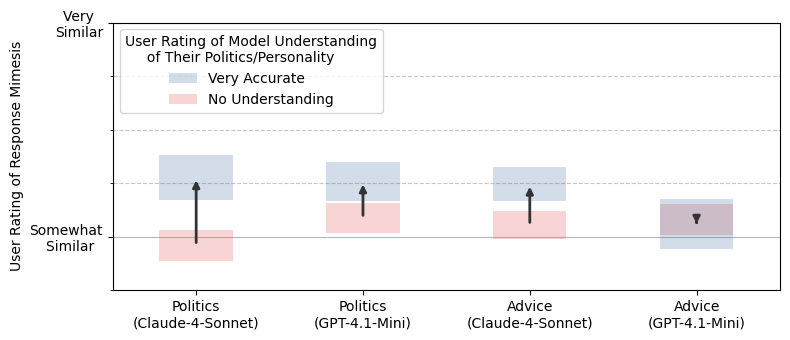

In [72]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter, MultipleLocator
from matplotlib.patches import Rectangle, Patch

categories = ["Politics\n(Claude-4-Sonnet)", "Politics\n(GPT-4.1-Mini)",
              "Advice\n(Claude-4-Sonnet)", "Advice\n(GPT-4.1-Mini)"]

# (start, end)
arrows = [(2.958871, 3.276227),
          (3.085915, 3.256834),
          (3.053055, 3.246056),
          (3.08036,  3.059757)]

# SE values (per row)
se_start = [0.072289, 0.070605, 0.064834, 0.072205]
se_end   = [0.104060, 0.091402, 0.079658, 0.116181]

fig, ax = plt.subplots(figsize=(8, 3.5))

# Width of shaded SE boxes
box_width = 0.44
start_color = "#E45756"  # muted teal
end_color   = "#4C78A8"  # soft coral
alpha = 0.25

for i, ((start, end), se_s, se_e) in enumerate(zip(arrows, se_start, se_end)):
    # Start SE box
    rect_start = Rectangle((i - box_width/2, start - se_s), box_width, 2*se_s,
                           facecolor=start_color, edgecolor='none', alpha=alpha, zorder=1)
    ax.add_patch(rect_start)
    # End SE box
    rect_end = Rectangle((i - box_width/2, end - se_e), box_width, 2*se_e,
                         facecolor=end_color, edgecolor='none', alpha=alpha, zorder=1)
    ax.add_patch(rect_end)

    # Arrow
    ax.annotate(
        "",
        xy=(i, end),
        xytext=(i, start),
        arrowprops=dict(arrowstyle="-|>", lw=2, color='0.2'),
        zorder=2
    )

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)

major_locs = [1, 2, 3, 4]
major_labels = ["Very\nDissimilar", "Somewhat\nDissimilar", "Somewhat\nSimilar  ", "Very  \nSimilar"]
ax.yaxis.set_major_locator(FixedLocator(major_locs))
ax.yaxis.set_major_formatter(FixedFormatter(major_labels))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_axisbelow(True)
ax.grid(True, which="major", axis="y", linestyle="-", alpha=0.9)
ax.grid(True, which="minor", axis="y", linestyle="--", alpha=0.7)

ax.set_xlim(-0.5, len(categories) - 0.5)
ax.set_ylim(2.75, 4)
ax.set_ylabel("User Rating of Response Mimesis")

handles = [
    Patch(facecolor=end_color,   alpha=alpha, label="Very Accurate"),
    Patch(facecolor=start_color, alpha=alpha, label="No Understanding"),
]
ax.legend(handles=handles, loc="upper left", frameon=True, title="User Rating of Model Understanding\n     of Their Politics/Personality")

plt.tight_layout()
plt.savefig("figures/mimesis_effects.jpg", dpi=300, bbox_inches="tight")
plt.show()





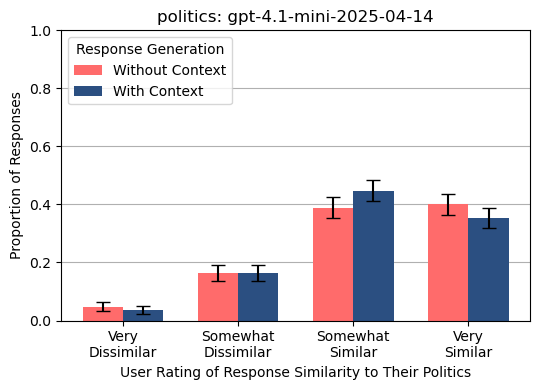

In [73]:
df = pd.read_csv("../data/survey_results.csv")
TASK = "politics"
MODEL = "gpt-4.1-mini-2025-04-14"
#MODEL = "claude-sonnet-4-20250514"
df = df[df["task"]==TASK]
df = df[df["model"]==MODEL]

mimesis_labels = {
    1: "Very\nDissimilar",
    2: "Somewhat\nDissimilar",
    3: "Somewhat\nSimilar",
    4: "Very\nSimilar"
}
df['mimesis_label'] = df['mimesis'].map(mimesis_labels)
# Get counts
counts = df.groupby(['mimesis_label', 'context']).size().unstack(fill_value=0)

# Reorder labels
ordered_labels = ["Very\nDissimilar", "Somewhat\nDissimilar", "Somewhat\nSimilar", "Very\nSimilar"]
counts = counts.reindex(ordered_labels)

# Total per context group (needed for proportions and SE)
totals = counts.sum()

# Compute proportions
proportions = counts.div(totals)

# Compute standard errors for binomial proportions: SE = sqrt(p * (1 - p) / n)
se = np.sqrt(proportions * (1 - proportions) / totals)

# Plot
fig, ax = plt.subplots(figsize=(5.5, 4))
bar_width = 0.35
x = np.arange(len(proportions))

# Plot each bar with error bars
ax.bar(x - bar_width/2, proportions[0], width=bar_width, yerr=se[0], capsize=5, label='Without Context', zorder=2, color="#FF6B6B")
ax.bar(x + bar_width/2, proportions[1], width=bar_width, yerr=se[1], capsize=5, label='With Context', zorder=2, color="#2B4F81")

# Formatting
ax.set_ylim(0,1)
ax.set_xticks(x)
ax.set_xticklabels(proportions.index, rotation=0)
xlabel = "User Rating of Response Similarity to Their Politics"
if TASK == "aita":
    xlabel = "User Rating of Response Similarity to Their Perspective"
ax.set_xlabel(xlabel)
ax.set_ylabel('Proportion of Responses')
ax.legend(title="Response Generation", loc="upper left")
ax.set_title(TASK + ": " + MODEL)
plt.gca().yaxis.grid(True, linestyle="-", zorder=1)  # optional readability

plt.tight_layout()
plt.show()

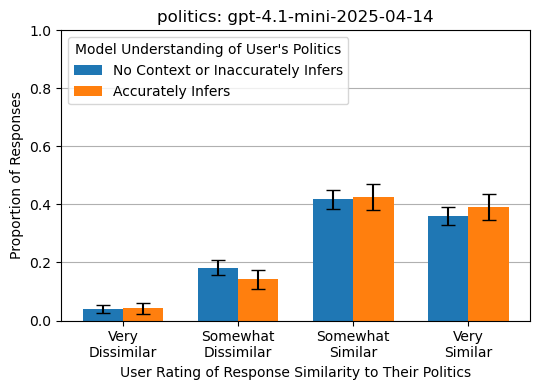

In [10]:
df = pd.read_csv("../data/survey_results.csv")
TASK = "politics"
#MODEL = "claude-sonnet-4-20250514"
MODEL = "gpt-4.1-mini-2025-04-14"
df = df[df["task"]==TASK]
df = df[df["model"]==MODEL]
df["understanding"] = (df["understanding"]>0).astype(int)
mimesis_labels = {
    -1.5: "Very\nDissimilar",
    -0.5: "Somewhat\nDissimilar",
     0.5: "Somewhat\nSimilar",
     1.5: "Very\nSimilar"
}
df['mimesis_label'] = df['mimesis'].map(mimesis_labels)
# Get counts
counts = df.groupby(['mimesis_label', 'understanding']).size().unstack(fill_value=0)

# Reorder labels
ordered_labels = ["Very\nDissimilar", "Somewhat\nDissimilar", "Somewhat\nSimilar", "Very\nSimilar"]
counts = counts.reindex(ordered_labels)

# Total per context group (needed for proportions and SE)
totals = counts.sum()

# Compute proportions
proportions = counts.div(totals)

# Compute standard errors for binomial proportions: SE = sqrt(p * (1 - p) / n)
se = np.sqrt(proportions * (1 - proportions) / totals)

# Plot
fig, ax = plt.subplots(figsize=(5.5, 4))
bar_width = 0.35
x = np.arange(len(proportions))

# Plot each bar with error bars
ax.bar(x - bar_width/2, proportions[0], width=bar_width, yerr=se[0], capsize=5, label='No Context or Inaccurately Infers', zorder=2)
ax.bar(x + bar_width/2, proportions[1], width=bar_width, yerr=se[1], capsize=5, label='Accurately Infers', zorder=2)

# Formatting
ax.set_ylim(0,1)
ax.set_xticks(x)
ax.set_xticklabels(proportions.index, rotation=0)
xlabel = "User Rating of Response Similarity to Their Politics"
if TASK == "aita":
    xlabel = "User Rating of Response Similarity to Their Perspective"
ax.set_xlabel(xlabel)
ax.set_ylabel('Proportion of Responses')
ax.legend(title="Model Understanding of User's Politics", loc="upper left")
ax.set_title(TASK + ": " + MODEL)
plt.gca().yaxis.grid(True, linestyle="-", zorder=1)  # optional readability

plt.tight_layout()
plt.show()

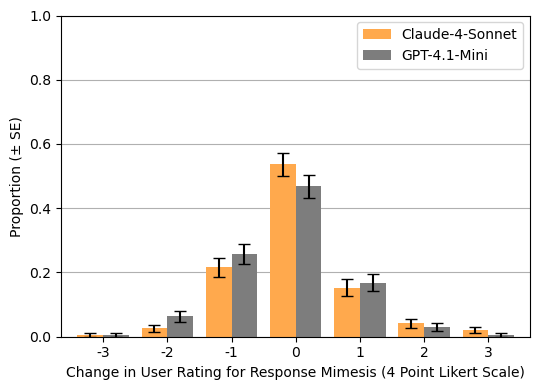

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("../data/regression/mimesis_change.csv")
TASK = "aita"
df = df[df["task"] == TASK]
# Count per (mimesis_change, model)
counts = df.groupby(['mimesis_change', 'model']).size().unstack(fill_value=0)

# Totals per model (n)
n_per_model = counts.sum(axis=0)

# Proportions per bin
props = counts.divide(n_per_model, axis=1)

# Standard error of proportions for each bin/model: sqrt( p*(1-p) / n )
se_props = np.sqrt(props * (1 - props) / n_per_model)

# Custom colors per model (make sure column order maps correctly)
color_map = {
    "claude-sonnet-4-20250514": "#FFA94D",
    "gpt-4.1-mini-2025-04-14": "#7D7D7D"
}
bar_colors = [color_map[m] for m in props.columns]

# Plot grouped bars with SE error bars
ax = props.plot(
    kind="bar",
    yerr=se_props,
    width=0.8,
    figsize=(5.5, 4),
    color=bar_colors,
    capsize=4,
    ecolor="black",
    zorder=2
)

plt.xlabel("Change in User Rating for Response Mimesis (4 Point Likert Scale)")
plt.ylabel("Proportion (± SE)")
# Optional: include sample sizes in legend labels
handles, labels = ax.get_legend_handles_labels()
model_label_map = {
    "claude-sonnet-4-20250514": "Claude-4-Sonnet",
    "gpt-4.1-mini-2025-04-14": "GPT-4.1-Mini"
}
legend_labels = [model_label_map[m] for m in props.columns]
ax.legend(handles, legend_labels)
plt.gca().yaxis.grid(True, linestyle="-", zorder=-1)  # optional readability
plt.xticks(rotation=0)
plt.ylim(0, 1)  # proportions
plt.tight_layout()
plt.savefig(f"figures/mimesis_change_{TASK}.jpg", dpi=300, bbox_inches="tight")
plt.show()

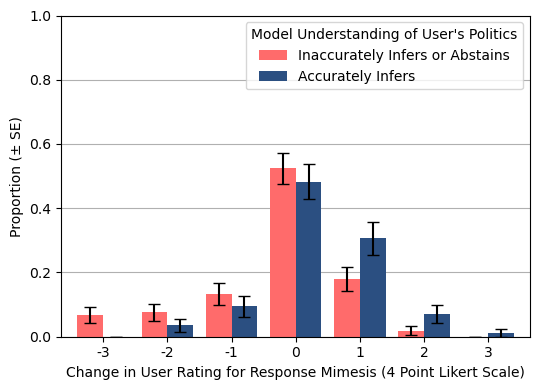

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("../data/regression/mimesis_change.csv")
TASK = "politics"
#MODEL = "gpt-4.1-mini-2025-04-14"
MODEL = "claude-sonnet-4-20250514"

# Filter for task + model
df = df[(df["task"] == TASK) & (df["model"] == MODEL)]

# Binary understanding: 1 if >3, else 0
df["understanding"] = (df["understanding"] > 3).astype(int)

# Count per (mimesis_change, understanding)
counts = df.groupby(["mimesis_change", "understanding"]).size().unstack(fill_value=0)

# Ensure both understanding levels exist as columns
counts = counts.reindex(columns=[0, 1], fill_value=0)

# Totals by understanding level (denominator for proportions)
n_per_understanding = counts.sum(axis=0)  # column-wise: {0: n0, 1: n1}

# Proportions normalized by understanding level (each column sums to 1)
props = counts.divide(n_per_understanding, axis=1)

# Standard error for each cell: sqrt(p*(1-p)/n_understanding)
se_props = np.sqrt(props * (1 - props) / n_per_understanding)

# Colors: gray for understanding=0, orange for understanding=1
color_map = {0: "#FF6B6B", 1: "#2B4F81"}
bar_colors = [color_map[col] for col in props.columns]

# Plot grouped bars with SE error bars
ax = props.plot(
    kind="bar",
    yerr=se_props,
    figsize=(5.5, 4),
    width=0.8,
    color=bar_colors,
    capsize=4,
    ecolor="black",
    zorder=2
)

plt.xlabel("Change in User Rating for Response Mimesis (4 Point Likert Scale)")
plt.ylabel("Proportion (± SE)")

# Legend with sample sizes per understanding level
handles, _ = ax.get_legend_handles_labels()
labels = ["Inaccurately Infers or Abstains",
          "Accurately Infers"]
if TASK=="politics":
    legend_title = "Model Understanding of User's Politics"
else:
    legend_title = "Model Understanding of User's Personality"

ax.legend(handles, labels, title=legend_title)
plt.gca().yaxis.grid(True, linestyle="-", zorder=-1)
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(f"figures/mimesis_change_by_understanding_{MODEL}_{TASK}.jpg", dpi=300, bbox_inches="tight")
plt.show()



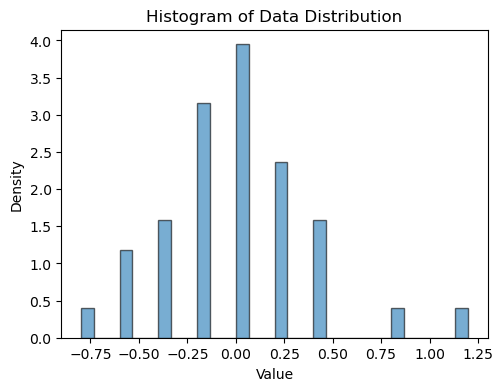

In [15]:
df = pd.read_csv("../data/regression/mimesis_change.csv")
TASK = "politics"
MODEL = "gpt-4.1-mini-2025-04-14"
#MODEL = "claude-sonnet-4-20250514"

# Filter for task + model
df = df[(df["task"] == TASK) & (df["model"] == MODEL)]

props = []
for p in df["user_id"].unique():
    curr = df[df["user_id"]==p]
    p = curr["mimesis_change"].mean()
    props.append(p)

plt.figure(figsize=(5.5, 4))
plt.hist(props, bins=30, density=True, alpha=0.6, edgecolor='black')
plt.title("Histogram of Data Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()
